In [40]:
"""
Description: Inspection and visualization of the 'sleep-export2.csv' file.
File source: downloaded from link in ./instructions.ipynb (see Part 2)

App Source: https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.html
"""

"\nDescription: Inspection and visualization of the 'sleep-export2.csv' file.\nFile source: downloaded from link in ./instructions.ipynb (see Part 2)\n\nApp Source: https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.html\n"

In [41]:
#General imports 
import sys
import os
from datetime import datetime, timedelta, date
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
from retrieve_time import Retrieve_Timestamps

In [42]:
#Initialize relevant variables
M = {}
time_format = '%Y-%m-%d %H:%M:%S.%f'

## Collect and treat the data

In [43]:
#Read the sleep data.
fpath = './../data/sleep-export2.csv'
data = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)

#Rename columns for simplicity.
newcols = {col : col.replace('com.samsung.health.sleep.', '') for col in data.columns}
data.rename(columns=newcols, inplace=True)    

In [44]:
#Use the Retrieve_Timestamps class to convert timestamps to readable values.
starttime_obj = Retrieve_Timestamps(
  data['start_time'].values/1000., data['time_offset'].values, 'UTC', 'milisec', time_format).out
endtime_obj = Retrieve_Timestamps(
  data['end_time'].values/1000., data['time_offset'].values, 'UTC', 'milisec', time_format).out

#Compute hour of the day the measurement started.
data['start_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in starttime_obj])

duration = endtime_obj - starttime_obj
data['duration'] = np.array([t.days*24.*60 + t.seconds/60. for t in duration]) #In minutes

ref_date = min(starttime_obj)
time_prog = starttime_obj - ref_date
data['time_prog'] = np.array([t.days + t.seconds/86400. for t in time_prog]) #In days

data.sort_values(by ='time_prog', inplace=True)


## Time range

In [45]:
print('Start date: ', (min(starttime_obj)))
print('End date: ', (max(starttime_obj)))

Start date:  2017-12-15 20:02:00-04:00
End date:  2018-07-28 21:04:00-03:00


In [46]:
#Output the data of some columns.
print(Counter(data['has_sleep_data'].values))

Counter({1.0: 277, nan: 1, nan: 1})


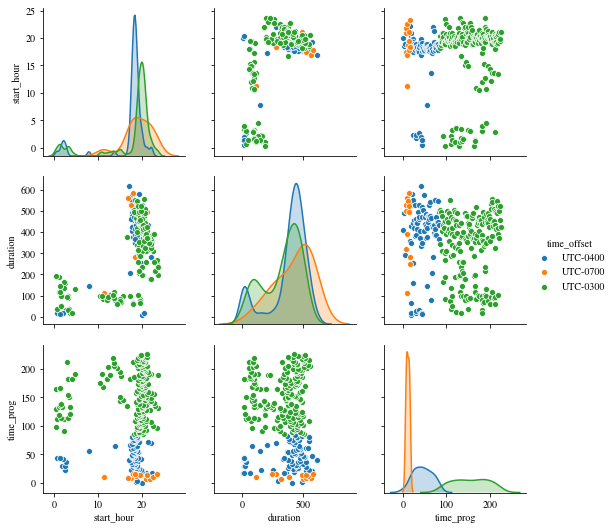

In [47]:
#Select relevant columns and make corner plot.
pair_cols = ['start_hour', 'duration', 'time_prog', 'time_offset']
df2 = data[pair_cols]
g = sns.pairplot(df2, hue='time_offset')

## Analyse sleep based on days since timezone change

In [48]:
#The following doesn't work because the time between entries is not always 1d.
#Check if timezone has changed in the day before.
data['tz_change_1d'] = data.time_offset != data.time_offset.shift(1)
#Set first element to false as it is compared to NaN.
data['tz_change_1d'].iloc[0] = False

#Check if timezone has changed 3 days ago and then remaind the same.
data['tz_change_3d'] = (
  (data.time_offset == data.time_offset.shift(1))
  & (data.time_offset == data.time_offset.shift(2))
  & (data.time_offset != data.time_offset.shift(3)))
#Set first three elements to false as they are compared to NaN.
data['tz_change_3d'].iloc[0:3] = False


In [49]:
#Compute number of days since time zone change.
time_since = 0.
tz_duration = []

for ((index2,row2),(index1,row1)) in zip(data.shift(1).iterrows(),data.iterrows()):
    if row1['time_offset'] == row2['time_offset']:
        time_since += (row1['time_prog'] - row2['time_prog']) #Additional time transpired since the tz changed.
    else:
        time_since = 0.
    tz_duration.append(time_since)

tz_duration = np.array(tz_duration)    
    
data['tz_duration'] = tz_duration

#We don't know for how long the person had been on the initial time zone.
data['tz_duration'].iloc[0:3] = np.nan

#We do not need tz_duration to be fine for plotting purposes.
def coarsify_duration(x):
    if abs(x - 0.) < 1.e-5:
        return 0
    elif (x > 0.) and (x<=1.5):
        return 1
    elif (x > 1.5) and (x <= 3.5):
        return 3
    elif (x > 3.5) and (x < 7.5):
        return 7
    elif x > 7.5:
        return 10

data['tz_coarse_duration'] = data['tz_duration'].apply(lambda x: coarsify_duration(x))

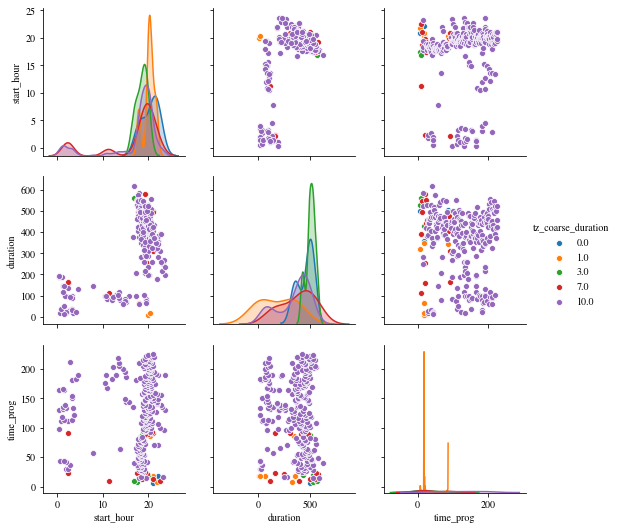

In [50]:
#Select relevant columns and make corner plot.
pair_cols = ['start_hour', 'duration', 'time_prog', 'tz_coarse_duration']
df2 = data[pair_cols]
df2.dropna(subset=['tz_coarse_duration'])
g = sns.pairplot(df2, vars=['start_hour', 'duration', 'time_prog'], hue='tz_coarse_duration')